In [1]:
from google.colab import drive
drive.mount('/content/drive')

!ln -s /content/drive/MyDrive/OkraInsight/.ipynb_checkpoints ./
!ln -s /content/drive/MyDrive/OkraInsight/training_data ./

!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ze8lr7xl
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ze8lr7xl
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=787698fc4c27734c5615c3d49251e2612d729b71c473e5e08fdbc08691649b71
  Stored in directory: /tmp/pip-ephem-wheel-cache-rdxcvuht/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [2]:
import torch
import torchvision
import os
import sys
import torch
import glob
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np
from segment_anything import sam_model_registry, SamPredictor

sys.path.append("..")

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

# !{sys.executable} -m pip install opencv-python matplotlib


#!mkdir images
#!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
#!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
# !cp /content/drive/MyDrive/OkraInsight/.ipynb_checkpoints/sam_vit_h_4b8939.pth ./

PyTorch version: 2.1.0+cu118
Torchvision version: 0.16.0+cu118
CUDA is available: True


In [3]:
using_colab = True

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_segment_only(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 1])
    h, w = mask.shape[-2:]
    inv_mask = 1 - mask
    mask_image = inv_mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_image(images, imageid):
    plt.figure(figsize=(10,10))
    plt.imshow(images[imageid])
    plt.axis('on')
    plt.show()

def show_image_with_points(images, input_points, input_label, imageid):
    plt.figure(figsize=(10,10))
    plt.imshow(images[imageid])
    show_points(input_points[imageid], input_label, plt.gca())
    plt.axis('on')
    plt.show()

def show_image_with_mask_points(name, image, mask, score, input_points, input_label):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_points, input_label, plt.gca())
    plt.title(f"{name} : Mask {maxid}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

def show_image_with_mask(pathname, image, mask):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    plt.title(f"{pathname} ", fontsize=18)
    plt.axis('off')
    plt.show()

In [5]:
sam_checkpoint = ".ipynb_checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [128]:
input_points = np.array([
    [[1600, 2500], [1600, 3600]],
    [[1600, 2500], [1600, 3300]],
    [[1100, 2500], [1100, 3300]],
    [[1250, 2500], [1250, 3300]],
    [[1600, 2500], [1600, 3600]],
    [[1500, 2500], [1500, 3400]],
    [[1480, 2500], [1480, 3400]],
    [[1480, 2500], [1480, 3400]],
    [[1375, 1500], [1375, 2000]],
    [[1375, 1500], [1375, 2000]],
    [[1375, 1500], [1375, 2000]],
    [[1375, 1500], [1375, 2000]],
    [[1850, 1500], [1850, 2000]],
    [[1625, 1500], [1625, 2000]],
    [[1625, 1500], [1625, 2000]],
    [[1625, 1500], [1625, 2000]],
    [[1625, 1500], [1625, 2000]],
    [[1625, 1500], [1625, 2000]],
    [[1625, 1500], [1625, 2000]],
    [[1625, 1500], [1625, 2000]],
    [[1625, 1500], [1625, 2000]],
    [[1250, 1500], [1250, 2000]],
    [[1375, 1500], [1375, 2000]],
    [[1375, 1500], [1375, 2000]],
    [[1625, 1500], [1625, 2000]],
    [[1375, 1500], [1375, 2000]],
    [[1375, 1500], [1375, 2000]],
    [[1750, 1500], [1750, 2000]],
    [[1500, 1500], [1500, 2000]],
    [[1500, 1500], [1500, 2000]],
    [[1500, 1500], [1500, 2000]],
    [[1400, 1500], [1400, 2000]],
    [[1500, 1500], [1500, 2000]],
    [[1500, 1500], [1500, 2000]],
    [[1650, 1500], [1650, 2000]],
    [[1375, 1500], [1375, 2000]],
    [[1375, 1500], [1375, 2000]],
    [[1500, 1500], [1500, 2000]],
    [[1375, 1500], [1375, 2000]],
    [[1500, 1500], [1500, 2000]],
    [[1500, 1500], [1500, 2000]],
    [[1500, 1500], [1500, 2000]],
    [[1500, 1500], [1500, 2000]],
    [[1500, 1500], [1500, 2000]],
    [[1500, 1500], [1500, 2000]],
    [[1500, 1500], [1500, 2000]],
    [[1300, 1500], [1300, 2000]],
    [[1500, 1500], [1500, 2000]],
    [[1100, 1500], [1100, 2000]],
    [[1500, 1500], [1500, 2000]],
    [[1500, 1550], [1700, 1550]],
    [[1500, 1500], [1700, 1500]]
    ])
input_label = np.array([1, 1])

In [7]:
image_paths = glob.glob('./training_data/okra_images/class_okra_surface/*.jpeg')
print(image_paths)

['./training_data/okra_images/class_okra_surface/IMG_9156.jpeg', './training_data/okra_images/class_okra_surface/IMG_9164.jpeg', './training_data/okra_images/class_okra_surface/IMG_9155.jpeg', './training_data/okra_images/class_okra_surface/IMG_9161.jpeg', './training_data/okra_images/class_okra_surface/IMG_9185.jpeg', './training_data/okra_images/class_okra_surface/IMG_9186.jpeg', './training_data/okra_images/class_okra_surface/IMG_9177.jpeg', './training_data/okra_images/class_okra_surface/IMG_9182.jpeg', './training_data/okra_images/class_okra_surface/IMG_9197.jpeg', './training_data/okra_images/class_okra_surface/IMG_9211.jpeg', './training_data/okra_images/class_okra_surface/IMG_9212.jpeg', './training_data/okra_images/class_okra_surface/IMG_9189.jpeg', './training_data/okra_images/class_okra_surface/IMG_9219.jpeg', './training_data/okra_images/class_okra_surface/IMG_9227.jpeg', './training_data/okra_images/class_okra_surface/IMG_9224.jpeg', './training_data/okra_images/class_okra

['./training_data/okra_images/class_okra_surface/IMG_9156.jpeg', './training_data/okra_images/class_okra_surface/IMG_9164.jpeg', './training_data/okra_images/class_okra_surface/IMG_9155.jpeg', './training_data/okra_images/class_okra_surface/IMG_9161.jpeg', './training_data/okra_images/class_okra_surface/IMG_9185.jpeg', './training_data/okra_images/class_okra_surface/IMG_9186.jpeg', './training_data/okra_images/class_okra_surface/IMG_9177.jpeg', './training_data/okra_images/class_okra_surface/IMG_9182.jpeg', './training_data/okra_images/class_okra_surface/IMG_9197.jpeg', './training_data/okra_images/class_okra_surface/IMG_9211.jpeg', './training_data/okra_images/class_okra_surface/IMG_9212.jpeg', './training_data/okra_images/class_okra_surface/IMG_9189.jpeg', './training_data/okra_images/class_okra_surface/IMG_9219.jpeg', './training_data/okra_images/class_okra_surface/IMG_9227.jpeg', './training_data/okra_images/class_okra_surface/IMG_9224.jpeg', './training_data/okra_images/class_okra_surface/IMG_9223.jpeg', './training_data/okra_images/class_okra_surface/IMG_9220.jpeg', './training_data/okra_images/class_okra_surface/IMG_9232.jpeg', './training_data/okra_images/class_okra_surface/IMG_9231.jpeg', './training_data/okra_images/class_okra_surface/IMG_9252.jpeg', './training_data/okra_images/class_okra_surface/IMG_9235.jpeg', './training_data/okra_images/class_okra_surface/IMG_9268.jpeg', './training_data/okra_images/class_okra_surface/IMG_9263.jpeg', './training_data/okra_images/class_okra_surface/IMG_9267.jpeg', './training_data/okra_images/class_okra_surface/IMG_9275.jpeg', './training_data/okra_images/class_okra_surface/IMG_9280.jpeg', './training_data/okra_images/class_okra_surface/IMG_9284.jpeg', './training_data/okra_images/class_okra_surface/IMG_9276.jpeg', './training_data/okra_images/class_okra_surface/IMG_9283.jpeg', './training_data/okra_images/class_okra_surface/IMG_9291.jpeg', './training_data/okra_images/class_okra_surface/IMG_9292.jpeg']

In [8]:
def is_iterable(object):
    try:
        iter(object)
    except TypeError:
        return False
    else:
        return True

is_iterable(image_paths)
path_id = 0
it = iter(image_paths)

In [124]:
try:
  path = next(it)
  path_id += 1
  print("path ", path_id, "of" , len(image_paths), ":" , path)
except StopIteration:
  print("Reached end of iteration. last count is ", path_id)
except Exception as e: print(e)

path  51 of 51 : ./training_data/okra_images/class_okra_surface/IMG_9288.jpeg


In [125]:
image_base_name = os.path.splitext(os.path.basename(path))[0]
outpath = './training_data/okra_segmentation_target_masks/' + image_base_name + ".segmask"

In [126]:
print(input_points[path_id])

[[1500 1500]
 [1500 2000]]


mask output at  ./training_data/okra_segmentation_target_masks/IMG_9288.segmask


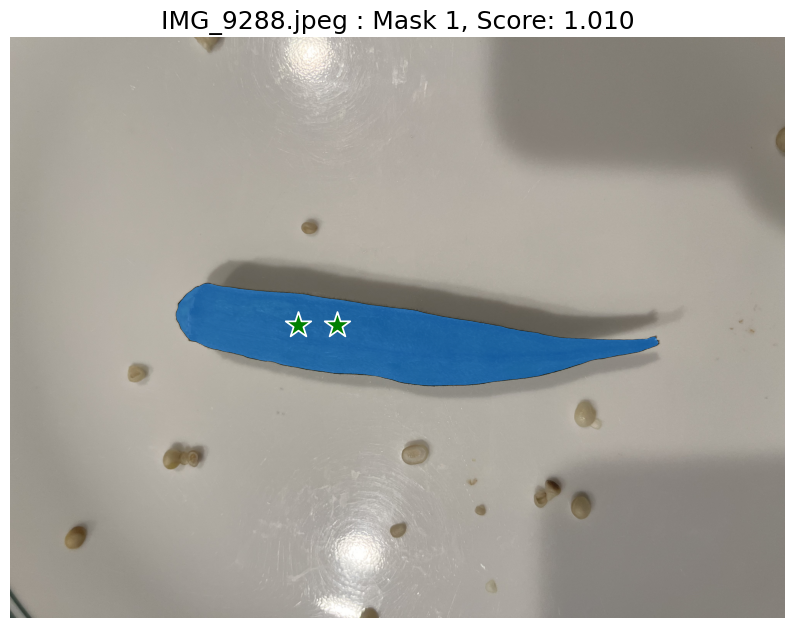

In [129]:
print("mask output at ", outpath)
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


predictor.set_image(image)

masks, scores, logits = predictor.predict(
  point_coords=input_points[path_id],
  point_labels=input_label,
  multimask_output=True,
)

maxid = scores.argmax(axis=0)
best_mask = masks[maxid]
best_mask_int = best_mask.astype(int)

show_image_with_mask_points(image_base_name+".jpeg", image, best_mask, scores[maxid], input_points[path_id], input_label)

In [130]:
with open(outpath, 'wb') as file:
  best_mask_int.dump(file)

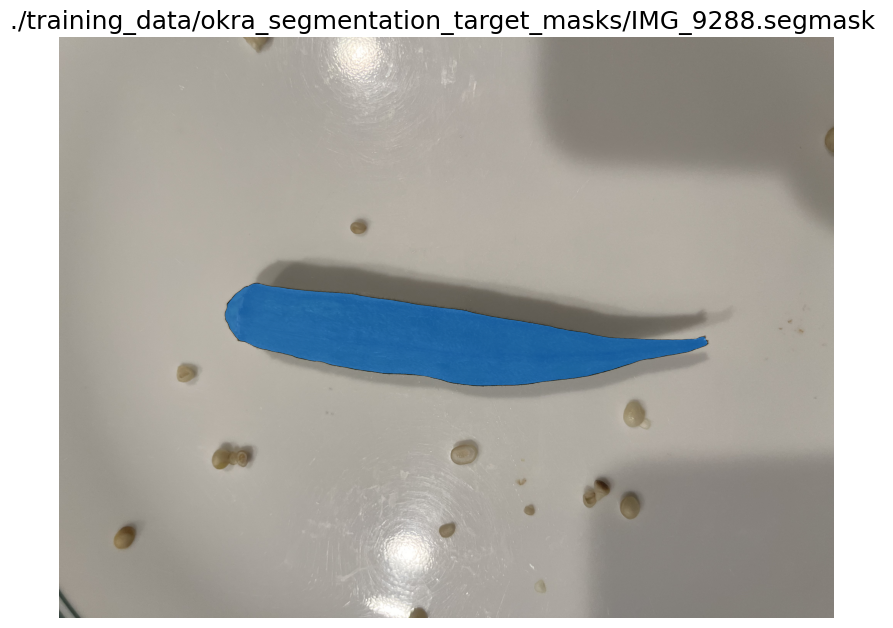

In [131]:
with open(outpath, 'rb') as file:
  testmask = pickle.load(file).astype(bool)

show_image_with_mask(outpath, image, testmask)